In [ ]:
import torch as pt

mols_nist = pt.load('./data/mine/f_nist_pre.pt')
print(len(mols_nist))

In [ ]:
import numpy as np

inten_list = []
inten_05_list = []
inten_04_list = []
inten_03_list = []
for mol in mols_nist:
    intensity = mol.intensities
    inten_list.append(intensity)
    inten_05_list.append(np.power(intensity, 0.5))
    inten_04_list.append(np.power(intensity, 0.4))
    inten_03_list.append(np.power(intensity, 0.3))
    
inten_list = np.concatenate(inten_list)
inten_05_list = np.concatenate(inten_05_list)
inten_04_list = np.concatenate(inten_04_list)
inten_03_list = np.concatenate(inten_03_list)

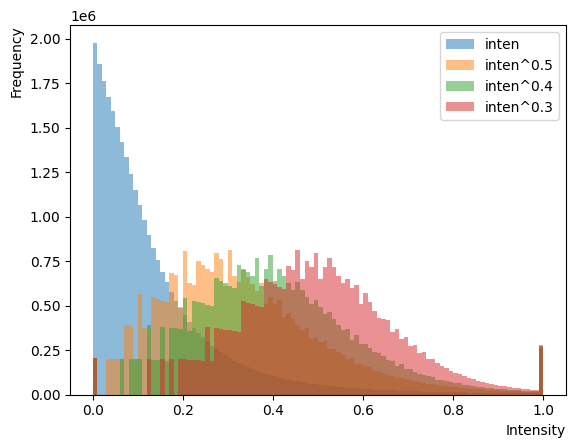

In [ ]:
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot()
ax.hist(inten_list, bins=100, alpha=0.5, label='inten')
ax.hist(inten_05_list, bins=100, alpha=0.5, label='inten^0.5')
ax.hist(inten_04_list, bins=100, alpha=0.5, label='inten^0.4')
ax.hist(inten_03_list, bins=100, alpha=0.5, label='inten^0.3')
ax.set_ylabel('Frequency', loc='top')
ax.set_xlabel('Intensity', loc='right')
ax.legend()
fig.savefig('intensity_hist.svg', format='svg', dpi=500)

In [1]:
import torch as pt

mols_test = pt.load('./data/mine/test_11499.pt')
print(len(mols_test))
mols_test_rep = pt.load('./data/mine/test_11499_rep.pt')
print(len(mols_test_rep))
mols_all = pt.load('./data/mine/mols_all.pt')
print(len(mols_all))
extra10 = pt.load('./data/mine/extra10.pt')
print(len(extra10))

11499
11499
2253216
10


In [2]:
mass_lib = [float(x.metadata['nominal_mass']) for x in mols_all]
mass_test = [float(x.metadata['nominal_mass']) for x in mols_test]

In [3]:
from torch.utils.data import DataLoader
from utils.data import SpecDataset, collate_fun_emb


dataset_test = SpecDataset(mols_test)
loader_test = DataLoader(dataset_test, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_lib = SpecDataset(mols_all)
loader_lib = DataLoader(dataset_lib, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
# dataset_extra10 = SpecDataset(extra10)
# loader_extra10 = DataLoader(dataset_extra10, batch_size=10, shuffle=False,
#                             num_workers=1, collate_fn=collate_fun_emb)

In [4]:
from utils.model import Spec2Emb

gpu=6
model = Spec2Emb().to(gpu)
model.load_state_dict(pt.load('./model/base_peak0.01_epoch4.pth', map_location='cpu'))

<All keys matched successfully>

In [5]:
from utils.data import gen_embeddings, build_idx
from utils.tools import calculate_hit_rate


embeddings_lib = gen_embeddings(model, loader_lib, gpu)
embeddings_test = gen_embeddings(model, loader_test, gpu)
embeddings_lib[:,-1] = mass_lib
embeddings_test[:,-1] = mass_test

I_mass_05_exp, _ = build_idx(embeddings_lib, embeddings_test, gpu)
top1_mass_05_exp, top10_mass_05_exp = calculate_hit_rate(mols_test, I_mass_05_exp, mols_all)
print(top1_mass_05_exp, top10_mass_05_exp)
I_mass_05_in, _ = build_idx(embeddings_lib[:2146690], embeddings_test, gpu)
top1_mass_05_in, top10_mass_05_in = calculate_hit_rate(mols_test, I_mass_05_in, mols_all)
print(top1_mass_05_in, top10_mass_05_in)

Searching time:  0:00:01.572605
0.45490912253239413 0.85320462648926
Searching time:  0:00:01.483032
0.4583007218018958 0.8572049743455953


In [6]:
from utils.data import gen_embeddings, build_idx


embeddings_lib = gen_embeddings(model, loader_lib, gpu, power=0.4)
embeddings_test = gen_embeddings(model, loader_test, gpu, power=0.4)
embeddings_lib[:,-1] = mass_lib
embeddings_test[:,-1] = mass_test

I_mass_04_exp, _ = build_idx(embeddings_lib, embeddings_test, gpu)
top1_mass_04_exp, top10_mass_04_exp = calculate_hit_rate(mols_test, I_mass_04_exp, mols_all)
print(top1_mass_04_exp, top10_mass_04_exp)
I_mass_04_in, _ = build_idx(embeddings_lib[:2146690], embeddings_test, gpu)
top1_mass_04_in, top10_mass_04_in = calculate_hit_rate(mols_test, I_mass_04_in, mols_all)
print(top1_mass_04_in, top10_mass_04_in)

Searching time:  0:00:01.555919
0.44351682755022176 0.8198104182972432
Searching time:  0:00:01.488110
0.44612575006522304 0.8228541612314114


In [ ]:
from collections import defaultdict
import numpy as np
from utils.data import gen_embeddings, build_idx
from utils.tools import calculate_hit_rate
from tqdm import tqdm


hit_rate_dict = defaultdict(list)
for power in tqdm(np.arange(0.3, 0.51, 0.01)):
    embs_lib = gen_embeddings(model, loader_lib, gpu, power)
    embs_test = gen_embeddings(model, loader_test, gpu, power)
    I_in, _ = build_idx(embs_lib[:2146690], embs_test, gpu, topk=200)
    top1_in, top10_in = calculate_hit_rate(mols_test, I_in, mols_all)
    hit_rate_dict['insilico_top1'].append(top1_in)
    hit_rate_dict['insilico_top10'].append(top10_in)

    I_ex, _ = build_idx(embs_lib, embs_test, gpu, topk=200)
    top1_ex, top10_ex = calculate_hit_rate(mols_test, I_ex, mols_all)
    hit_rate_dict['Expanded_top1'].append(top1_ex)
    hit_rate_dict['Expanded_top10'].append(top10_ex)
pt.save(hit_rate_dict, './data/mine/hit_rate_dict.pt')

In [5]:
import torch as pt

hit_rate_dict = pt.load('./data/mine/hit_rate_dict.pt')

print(np.argmax(hit_rate_dict['insilico_top1'])) # 0.42
print(np.argmax(hit_rate_dict['insilico_top10'])) # 0.43
print(np.argmax(hit_rate_dict['Expanded_top1'])) # 0.41
print(np.argmax(hit_rate_dict['Expanded_top10'])) # 0.46

11
12
10
15


In [6]:
print('power=0.4')
print(f'Expanded_top1: {100*hit_rate_dict["Expanded_top1"][10]:.2f}')
print(f'Expanded_top10: {100*hit_rate_dict["Expanded_top10"][10]:.2f}')
print(f'insilico_top1: {100*hit_rate_dict["insilico_top1"][10]:.2f}')
print(f'insilico_top10: {100*hit_rate_dict["insilico_top10"][10]:.2f}')
print('power=0.5')
print(f'Expanded_top1: {100*hit_rate_dict["Expanded_top1"][20]:.2f}')
print(f'Expanded_top10: {100*hit_rate_dict["Expanded_top10"][20]:.2f}')
print(f'insilico_top1: {100*hit_rate_dict["insilico_top1"][20]:.2f}')
print(f'insilico_top10: {100*hit_rate_dict["insilico_top10"][20]:.2f}')

power=0.4
Expanded_top1: 41.98
Expanded_top10: 81.35
insilico_top1: 42.29
insilico_top10: 81.82
power=0.5
Expanded_top1: 39.28
Expanded_top10: 80.48
insilico_top1: 39.58
insilico_top10: 80.86


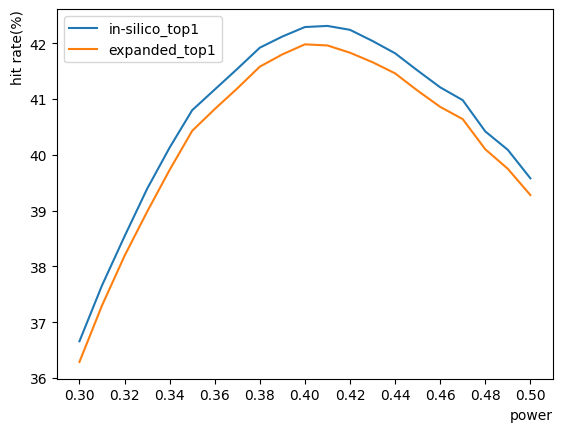

In [43]:
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot()
x_axis = np.arange(0.3, 0.51, 0.01)
ax.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['insilico_top1']], label='in-silico_top1')
# ax.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['insilico_top10']], label='in-silico_top10')
ax.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['Expanded_top1']], label='expanded_top1')
# ax.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['Expanded_top10']], label='expanded_top10')
ax.set_xticks(np.arange(0.3, 0.51, 0.02))
ax.set_xlabel('power', loc='right')
ax.set_ylabel('hit rate(%)', loc='top')
ax.legend()
fig.savefig('power_hit_rate_top1.svg', format='svg', dpi=500)
# fig.savefig('power_hit_rate_top10.svg', format='svg', dpi=500)

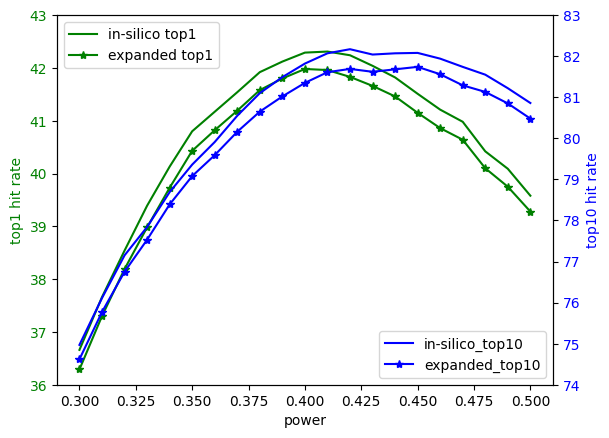

In [12]:
import matplotlib.pyplot as plt  
import numpy as np  

# 生成示例数据  
x_axis = np.arange(0.3, 0.51, 0.01)

# 创建一个新的图形  
fig, ax1 = plt.subplots()  

# 绘制左侧y轴的图  
ax1.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['insilico_top1']], 
        'g-',label='on in-silico lib')
ax1.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['Expanded_top1']], 
        'g*-',label='on expanded lib')
ax1.set_xlabel('power')  
ax1.set_ylim([36, 43])
ax1.set_xticks()
ax1.set_ylabel('top1 hit rate', color='g')  
ax1.tick_params(axis='y', labelcolor='g')  
ax1.legend(loc='upper left')

# 创建右侧y轴  
ax2 = ax1.twinx()  
ax2.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['insilico_top10']], 
            'b-',label='on in-silico lib') 
ax2.plot(x_axis, [round(100*x, 2) for x in hit_rate_dict['Expanded_top10']], 
        'b*-',label='on expanded lib')
ax2.set_ylim([74, 83])
ax2.set_ylabel('top10 hit rate', color='b')  
ax2.tick_params(axis='y', labelcolor='b')  
ax2.legend(loc='lower right')

# 显示图形  
plt.show()